# Modules to be imported

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#from sklearn.naive_bayes import GaussianNB
from scipy import stats

# Load Data

In [2]:
X_train = np.loadtxt('mnist/Xtrain.txt', delimiter=',')
y_train = np.loadtxt('mnist/label_train.txt')
X_test = np.loadtxt('mnist/Xtest.txt', delimiter=',')
y_test = np.loadtxt('mnist/label_test.txt')
Q = np.loadtxt('mnist/Q.txt', delimiter=',')
print X_train.shape, y_train.shape, X_test.shape, y_test.shape, Q.shape

(5000, 20) (5000,) (500, 20) (500,) (784, 20)


# KNN

In [3]:
class HomeMadeKNN(object):
    def __init__(self, k):
        self.k = k
        self.X = None
        self.y = None
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X):
        y = []
        for i in range(X.shape[0]):
            y.append(self._find(X[i, :]))
        return np.array(y)
    
    def _find(self, pnt):
        to_sort = []
        for i in range(self.X.shape[0]):
            to_sort.append((np.linalg.norm(pnt-self.X[i, :]), i))
        to_sort.sort(key=lambda x: x[0])
        lookup = {}
        for i in range(self.k):
            label = self.y[to_sort[i][1]]
            if label not in lookup:
                lookup[label] = 1
            else:
                lookup[label] += 1
        result = None
        for label in lookup:
            if not result: result = label
            else:
                if lookup[result] < lookup[label]:
                    result = label
        return result

## Train and Test KNN

In [4]:
misclassify = []
misindices = []
for k in range(1, 6):
    KNN = HomeMadeKNN(k)
    KNN.fit(X_train, y_train)
    y_predict = KNN.predict(X_test)
    con_mat = confusion_matrix(y_test, y_predict)
    print("KNN with {} neighbor(s) get accuracy {}".format(k, np.trace(con_mat)/500.0))
    if k in (1, 3, 5):
        indices = np.nonzero(y_test-y_predict)
        misclassify.append(y_predict[indices])
        misindices.append(indices[0])

KNN with 1 neighbor(s) get accuracy 0.948
KNN with 2 neighbor(s) get accuracy 0.926
KNN with 3 neighbor(s) get accuracy 0.936
KNN with 4 neighbor(s) get accuracy 0.934
KNN with 5 neighbor(s) get accuracy 0.936


## Draw Misclassified Images

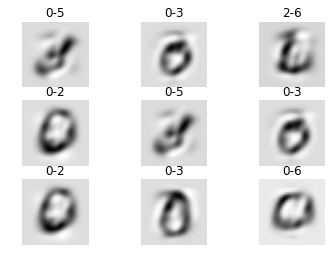

In [5]:
%matplotlib inline
f, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        img = np.dot(Q, X_test[misindices[i][j], :]).reshape((28, 28))
        ax[i, j].imshow(img, cmap='Greys')
        title = "{0}-{1}".format(int(y_test[misindices[i][j]]), int(misclassify[i][j]))
        ax[i, j].set_title(title)
        ax[i, j].axis('off')
plt.show()

# Naive Bayes with Gaussian Likelihood

In [6]:
class HomeMadeNB(object):
    def __init__(self):
        self.sigma_ = None
        self.theta_ = None
        self.class_prior_ = None
        self.labels = None
    
    def fit(self, X, y):
        freqs = stats.itemfreq(y)
        self.labels = freqs[:, 0]
        self.class_prior_ = freqs[:, 1] / y.size
        self.theta_ = np.zeros([self.labels.size, X.shape[1]])
        self.sigma_ = np.ones([self.labels.size, X.shape[1]])
        categorize = {}
        for label in self.labels:
            categorize[label] = np.empty([0, X.shape[1]])
        for i in range(X.shape[0]):
            categorize[y[i]] = np.vstack([categorize[y[i]], X[i, :]])
        for i in range(self.labels.size):
            for j in range(X.shape[1]):
                params = stats.norm.fit(categorize[self.labels[i]][:,j])
                self.theta_[i, j] = params[-2]
                self.sigma_[i, j] = params[-1]
    
    def predict(self, X):
        y = []
        for i in range(X.shape[0]):
            probas = []
            for j in range(self.labels.size):
                proba = self.class_prior_[j]
                for k in range(X.shape[1]):
                    proba *= stats.norm.pdf(X[i, k], loc=self.theta_[j, k], scale=self.sigma_[j, k])
                probas.append(proba)
            y.append(self.labels[probas.index(max(probas))])
        return np.array(y)
    
    def predict_proba(self, X):
        y = []
        for i in range(X.shape[0]):
            probas = []
            for j in range(self.labels.size):
                proba = self.class_prior_[j]
                for k in range(X.shape[1]):
                    proba *= stats.norm.pdf(X[i, k], loc=self.theta_[j, k], scale=self.sigma_[j, k])
                probas.append(proba)
            s = sum(probas)
            probas = map(lambda x: x / s, probas)
            y.append(probas)
        y = np.array(y)
        return y

## Train data and show ML estimates

In [7]:
NB = HomeMadeNB()
NB.fit(X_train, y_train)
print('MLE for means:')
print(NB.theta_)
print('MLE for variances:')
print(NB.sigma_)
print('Class priors')
print(NB.class_prior_)

MLE for means:
[[ -3.52573594e+00  -3.89083628e-01   5.93897069e-01   1.16964448e+00
   -7.62030525e-01  -3.44672522e-01   1.09893307e+00  -3.33337465e-01
   -9.18094649e-01  -3.23508189e-01   2.84791214e-02   3.25471920e-01
   -1.73233078e-01  -2.91269703e-02   2.35738517e-01   1.38729406e-01
    2.46639233e-01   2.41050177e-01   2.51656810e-02  -1.05856268e-01]
 [  1.83157236e-01  -8.91644917e-01   5.43363736e-01   7.98059020e-01
   -1.35453844e+00  -2.01511340e-01   1.14856656e+00  -4.41861754e-01
   -1.03885387e+00  -3.14544552e-01   2.99795627e-01   4.39470520e-01
    2.35091112e-02   3.13218409e-01   5.53836676e-01   3.05786460e-02
    4.58066759e-01   4.22162275e-01   2.84292590e-02  -6.49205591e-02]
 [ -1.72751215e+00  -6.50965796e-01   8.06662432e-01   1.51429138e-01
   -2.36943746e+00  -6.68956095e-01   1.22932233e+00   1.67337119e-01
   -4.83104738e-01  -4.15234264e-01   3.72385687e-01   3.47255417e-01
   -1.60757101e-01   4.81879008e-02  -1.62944202e-03   1.90459157e-01
   

## Show confusion matrix and Calculate Acc

In [32]:
y_predict = NB.predict(X_test)
con_mat = confusion_matrix(y_test, y_predict)
print('Confusion Matrix:')
print(con_mat)
print("NB with Gaussian likelihood get accuracy {}".format(np.trace(con_mat)/500.0))

Confusion Matrix:
[[44  0  1  0  0  2  3  0  0  0]
 [ 0 48  1  0  0  1  0  0  0  0]
 [ 0  0 38  3  0  2  2  0  5  0]
 [ 1  0  1 38  0  4  0  0  5  1]
 [ 0  1  0  0 44  1  0  0  0  4]
 [ 1  1  0  3  4 40  1  0  0  0]
 [ 0  0  0  0  5  4 40  0  0  1]
 [ 0  1  2  0  1  0  0 44  1  1]
 [ 1  1  0  0  0  1  1  0 45  1]
 [ 0  0  1  0  2  0  0  0  0 47]]
NB with Gaussian likelihood get accuracy 0.856


## Draw mean images for each class

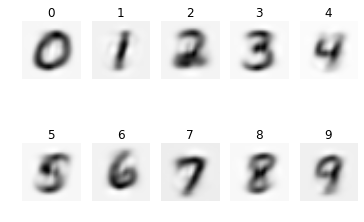

In [8]:
%matplotlib inline
f, ax = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        img = np.dot(Q, NB.theta_[i*5+j, :]).reshape((28, 28))
        ax[i, j].imshow(img, cmap='Greys')
        title = "{0}".format(i*5+j)
        ax[i, j].set_title(title)
        ax[i, j].axis('off')
plt.show()

## Show misclassified images and their posterori

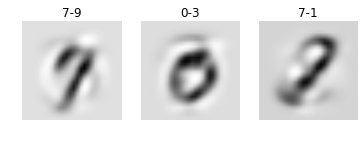

posterori for 0:
[  1.72688858e-05   1.26813457e-04   3.47352744e-04   1.68824274e-03
   2.08282831e-02   2.70606166e-02   1.44536812e-03   7.75761170e-01
   9.58252830e-04   1.71766631e-01]
posterori for 1:
[  5.39127161e-02   2.14607192e-13   4.83986068e-03   3.17534587e-01
   9.29565581e-03   9.93130255e-02   4.85417320e-01   2.75303235e-02
   4.77895638e-04   1.67861508e-03]
posterori for 2:
[  1.96855042e-04   6.01791438e-02   7.47515042e-01   2.53922787e-03
   6.63433212e-04   7.14861973e-04   6.52135235e-04   2.37699655e-04
   1.87261201e-01   4.04004777e-05]


In [9]:
indices = np.nonzero(y_test-y_predict)
misclassify = np.vstack([y_predict[indices], indices[0]])
samples = misclassify[:, np.random.randint(indices[0].size, size=3)]
%matplotlib inline
f, ax = plt.subplots(1, 3)
for i in range(3):
    img = np.dot(Q, X_test[int(samples[1, i]), :]).reshape((28, 28))
    ax[i].imshow(img, cmap='Greys')
    title = "{0}-{1}".format(int(y_test[int(samples[1, i])]), int(samples[0, i]))
    ax[i].set_title(title)
    ax[i].axis('off')
plt.show()
post = NB.predict_proba(X_test)
for i in range(3):
    print("posterori for {}:".format(i))
    print post[int(samples[1, i]), :]

# Softmax Classifier

In [66]:
class HomeMadeSoftmax(object):
    def __init__(self, ita, iterations):
        self.w = None
        self.labels = []
        self.ita = ita
        self.iterations = iterations
    
    def fit(self, X, y):
        freqs = stats.itemfreq(y)
        self.labels = list(freqs[:, 0])
        self.w = np.zeros([X.shape[1], len(self.labels)])
        delta = np.zeros([X.shape[1], len(self.labels)])
        likelihood = []
        for i in range(X.shape[0]):
            delta[:, self.labels.index(y[i])] += X[i, :]
        for i in range(self.iterations):
            to_update = np.copy(delta)
            likelihood.append(0.)
            exponent = np.exp(np.dot(X, self.w))
            for j in range(exponent.shape[0]):
                exponent[j, :] /= np.sum(exponent[j, :])
                likelihood[-1] += np.log(exponent[j, self.labels.index(y[j])])
            for k in range(to_update.shape[1]):
                to_minus = np.zeros(X.shape[1])
                for l in range(X.shape[0]):
                    to_minus += X[l, :] * exponent[l, k]
                to_update[:, k] -= to_minus
            self.w += self.ita * to_update
        return likelihood
        
    def predict(self, X):
        result = []
        for i in range(X.shape[0]):
            probas = []
            for j in range(self.w.shape[1]):
                probas.append(np.dot(X[i, :], self.w[:, j]))
            result.append(self.labels[probas.index(max(probas))])
        return np.array(result)
    
    def predict_proba(self, X):
        result = []
        for i in range(X.shape[0]):
            probas = []
            for j in range(self.w.shape[1]):
                probas.append(np.exp(np.dot(X[i, :], self.w[:, j])))
            denominator = sum(probas)
            result.append(map(lambda x: x/denominator, probas))
        return np.array(result)

## Train model and draw the evolution of likelihood

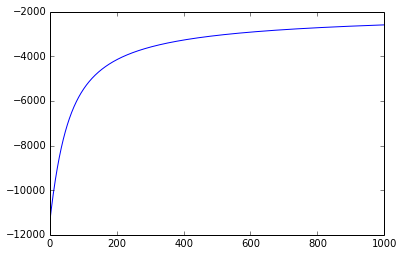

In [67]:
soft = HomeMadeSoftmax(0.1/5000, 1000)
add_one_train = np.ones([X_train.shape[0], 1])
likelihoods = soft.fit(np.hstack([X_train, add_one_train]), y_train)
%matplotlib inline
plt.plot(likelihoods)
plt.show()

## Calculate accuracy

In [69]:
add_one_test = np.ones([X_test.shape[0], 1])
y_predict = soft.predict(np.hstack([X_test, add_one_test]))
con_mat = confusion_matrix(y_test, y_predict)
print('Confusion Matrix:')
print(con_mat)
print("Home-made softmax classifier get accuracy {}".format(np.trace(con_mat)/500.0))

Confusion Matrix:
[[46  0  1  1  0  0  2  0  0  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 38  2  1  0  4  0  5  0]
 [ 1  0  2 39  0  2  0  1  5  0]
 [ 0  0  1  0 42  1  0  0  1  5]
 [ 1  1  0  4  2 39  1  0  0  2]
 [ 0  0  1  0  4  3 42  0  0  0]
 [ 0  0  3  0  1  0  0 44  1  1]
 [ 0  0  0  0  0  2  1  0 46  1]
 [ 0  1  1  0  3  0  0  1  0 44]]
Home-made softmax classifier get accuracy 0.858


## Show misclassified instances and display their distributions

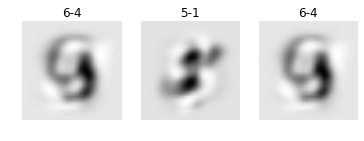

posterori for 0:
[ 0.00829482  0.01107798  0.06291947  0.07534041  0.42174891  0.02790394
  0.1844372   0.09517093  0.02394314  0.08916322]
posterori for 1:
[ 0.00358437  0.68413307  0.09222992  0.00752431  0.01550136  0.01650325
  0.01249437  0.04375087  0.10962164  0.01465684]
posterori for 2:
[ 0.00829482  0.01107798  0.06291947  0.07534041  0.42174891  0.02790394
  0.1844372   0.09517093  0.02394314  0.08916322]


In [72]:
indices = np.nonzero(y_test-y_predict)
misclassify = np.vstack([y_predict[indices], indices[0]])
samples = misclassify[:, np.random.randint(indices[0].size, size=3)]
%matplotlib inline
f, ax = plt.subplots(1, 3)
for i in range(3):
    img = np.dot(Q, X_test[int(samples[1, i]), :]).reshape((28, 28))
    ax[i].imshow(img, cmap='Greys')
    title = "{0}-{1}".format(int(y_test[int(samples[1, i])]), int(samples[0, i]))
    ax[i].set_title(title)
    ax[i].axis('off')
plt.show()
post = soft.predict_proba(np.hstack([X_test, add_one_test]))
for i in range(3):
    print("posterori for {}:".format(i))
    print post[int(samples[1, i]), :]